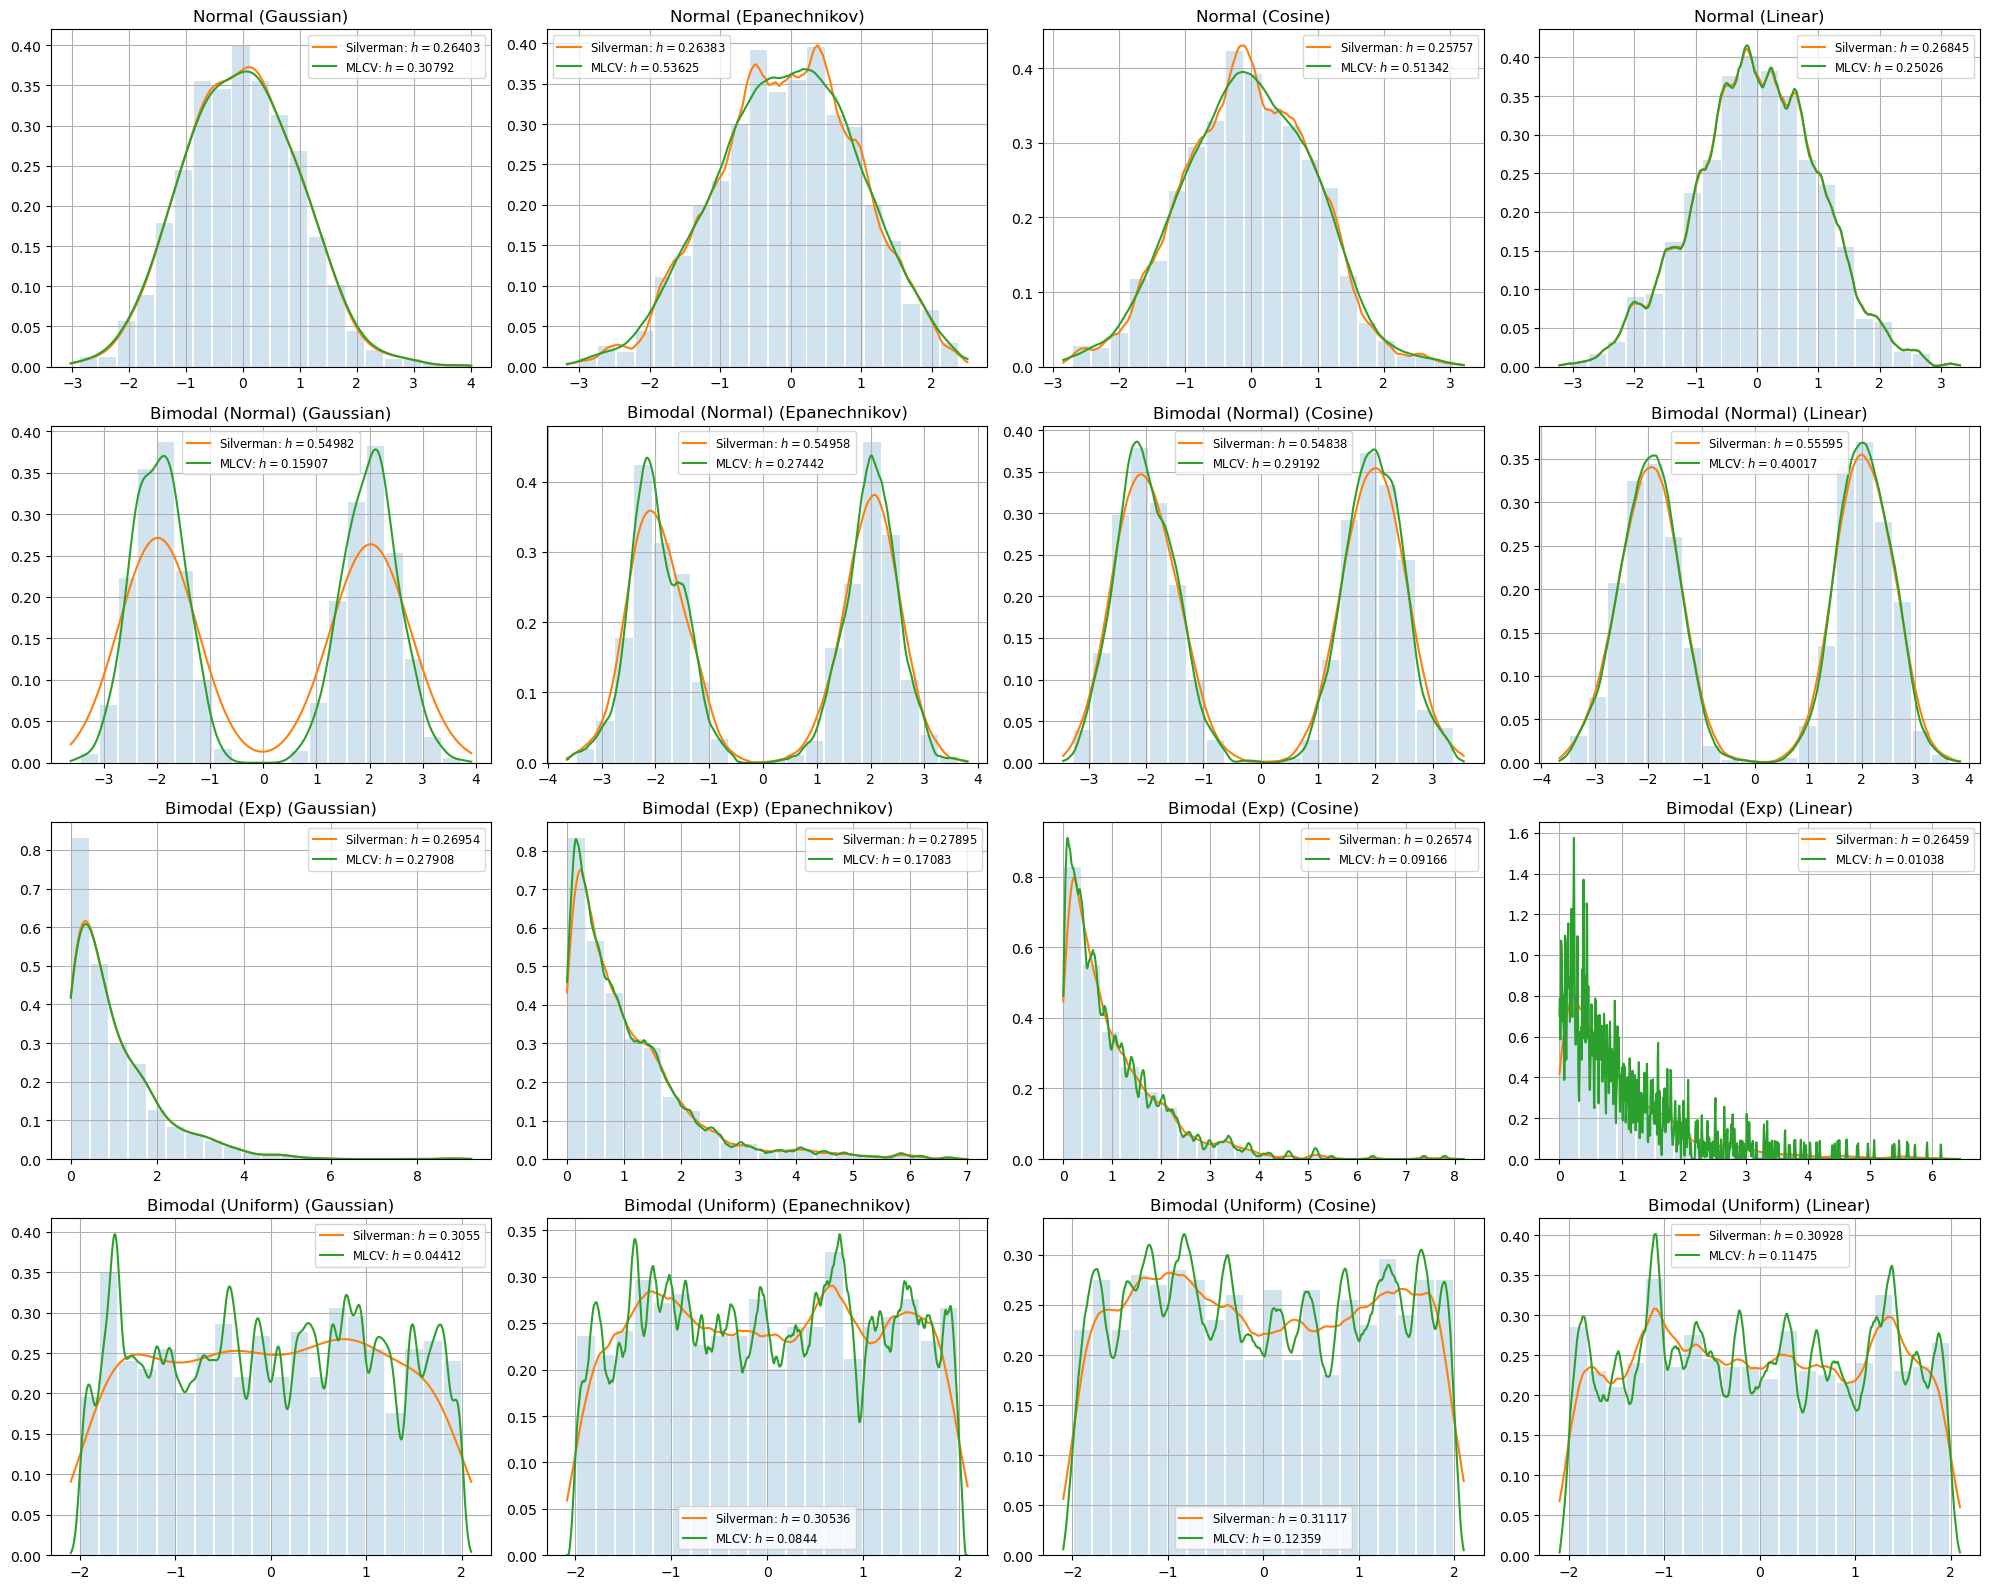

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Example distributions
def make_data_normal():
    return np.random.normal(0, 1, 1000), lambda x: (1 / np.sqrt(2 * np.pi)) * np.exp(-x**2 / 2)

def make_data_binormal():
    return np.concatenate([np.random.normal(-2, 0.5, 500), np.random.normal(2, 0.5, 500)]), \
           lambda x: (0.5 * (1 / np.sqrt(2 * np.pi * 0.5**2)) * np.exp(-(x + 2)**2 / (2 * 0.5**2))
                     + 0.5 * (1 / np.sqrt(2 * np.pi * 0.5**2)) * np.exp(-(x - 2)**2 / (2 * 0.5**2)))

def make_data_exp():
    return np.random.exponential(1, 1000), lambda x: np.exp(-x) * (x >= 0)

def make_data_uniform():
    return np.random.uniform(-2, 2, 1000), lambda x: (np.abs(x) <= 2) / 4

# Kernel Functions
def kernel(name):
    kernels = {
        'gaussian': lambda u: np.exp(-0.5 * u**2) / np.sqrt(2 * np.pi),
        'epanechnikov': lambda u: 0.75 * (1 - u**2) * (np.abs(u) <= 1),
        'cosine': lambda u: (np.pi / 4) * np.cos(np.pi * u / 2) * (np.abs(u) <= 1),
        'linear': lambda u: (1 - np.abs(u)) * (np.abs(u) <= 1)
    }
    return kernels[name]

# Bandwidth Estimation Methods
def bw_silverman(data):
    n = len(data)
    return 1.06 * np.std(data) * n ** (-1 / 5)

def bw_mlcv(data, k):
    n = len(data)
    def log_likelihood(h):
        likelihood = 0
        for i in range(n):
            leave_out = np.delete(data, i)
            kde_i = np.mean(k((data[i] - leave_out) / h)) / h
            if kde_i > 0:
                likelihood += np.log(kde_i)
        return -likelihood

    result = minimize(log_likelihood, 1.0, bounds=[(0.01, 10)], method='L-BFGS-B')
    return result.x[0]

# Kernel Density Estimation
def kde(data, h, k, x=None):
    if x is None:
        x = np.linspace(np.min(data), np.max(data), 1000)
    u = (x[:, None] - data) / h
    kde_values = np.mean(k(u), axis=1) / h
    return kde_values

# Data Configurations
data = [
    ('Normal', make_data_normal),
    ('Bimodal (Normal)', make_data_binormal),
    ('Bimodal (Exp)', make_data_exp),
    ('Bimodal (Uniform)', make_data_uniform)
]

kernels = [
    ('Gaussian', kernel('gaussian')),
    ('Epanechnikov', kernel('epanechnikov')),
    ('Cosine', kernel('cosine')),
    ('Linear', kernel('linear'))
]

bw_algorithms = [
    ('Silverman', bw_silverman),
    ('MLCV', bw_mlcv),
]

mses = []

def run_kde(ax, data, kernel):
    x, dist = data[1]()
    x_plot = np.linspace(np.min(x) * 1.05, np.max(x) * 1.05, 1000)
    ax.grid(True)
    ax.hist(x, density=True, alpha=0.2, bins=20, rwidth=0.9)
    for bw in bw_algorithms:
        h = bw[1](x) if bw[0] == 'Silverman' else bw[1](x, kernel[1])
        x_kde = kde(x, h, kernel[1], x_plot)
        mse = np.mean((dist(x_plot) - x_kde) ** 2)
        mses.append({'data': data[0], 'kernel': kernel[0], 'bw_algorithm': bw[0], 'h': round(h, 5), 'mse': round(mse * 1000, 5)})
        ax.plot(x_plot, x_kde, label=f'{bw[0]}: $h={round(h, 5)}$')
    ax.legend(loc='best', fontsize='small')
    ax.set_title(f'{data[0]} ({kernel[0]})')

fig, axs = plt.subplots(len(data), len(kernels), figsize=(20, 16))

for i, d in enumerate(data):
    for j, k in enumerate(kernels):
        run_kde(axs[i, j], d, k)

plt.tight_layout()
plt.show()

# Save the MSE results to a CSV file
pd.DataFrame(mses).to_csv('bw_eval.csv', index=False)
